# 03.2d: Jet Geometry - Testing the "Small but Close" Hypothesis

**Goal:** Determine whether the jet's large angular size is due to being physically small but close to the origin.

**Hypothesis:** The jet subtends a large angle in the hypersky because it's a small structure located close to the origin, rather than a large structure far away.

We'll compute:
1. **Jet centroid** in original γ (uncentered) coordinates
2. **Distance from origin** to jet centroid
3. **Jet intrinsic size** (spread around its own centroid)
4. **Angular size** (intrinsic size / distance from origin)
5. **Compare to bulk** for context

If jet is close to origin with small intrinsic size but large angular size, the hypothesis is confirmed!

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
# Load original gamma (uncentered)
gamma_path = Path(TENSOR_DIR) / "gamma_qwen3_4b_instruct_2507.safetensors"
gamma = load_file(gamma_path)['gamma']

N, d = gamma.shape

print(f"Loaded γ (original, uncentered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Load jet mask
jet_mask_path = Path(TENSOR_DIR) / "jet_mask.safetensors"
jet_mask = load_file(jet_mask_path)['jet_mask']

n_jet = jet_mask.sum().item()
n_bulk = (~jet_mask).sum().item()

print(f"Loaded jet mask:")
print(f"  Jet tokens: {n_jet:,} ({n_jet/N*100:.2f}%)")
print(f"  Bulk tokens: {n_bulk:,} ({n_bulk/N*100:.2f}%)")

Loaded γ (original, uncentered):
  Tokens: 151,936
  Dimensions: 2,560

Loaded jet mask:
  Jet tokens: 3,055 (2.01%)
  Bulk tokens: 148,881 (97.99%)


## Step 2: Compute Centroids

In [4]:
# Global centroid (entire cloud)
global_centroid = gamma.mean(dim=0)
global_centroid_norm = global_centroid.norm().item()

print(f"Global centroid (entire cloud):")
print(f"  Norm: {global_centroid_norm:.6f} gamma units")
print(f"  (This is the origin of the centered γ' frame)")
print()

# Jet centroid
jet_centroid = gamma[jet_mask].mean(dim=0)
jet_centroid_norm = jet_centroid.norm().item()

print(f"Jet centroid:")
print(f"  Norm: {jet_centroid_norm:.6f} gamma units")
print(f"  (Distance from true origin to jet center)")
print()

# Bulk centroid
bulk_centroid = gamma[~jet_mask].mean(dim=0)
bulk_centroid_norm = bulk_centroid.norm().item()

print(f"Bulk centroid:")
print(f"  Norm: {bulk_centroid_norm:.6f} gamma units")
print(f"  (Distance from true origin to bulk center)")
print()

# Compute offset between jet and global centroid
jet_offset = jet_centroid - global_centroid
jet_offset_norm = jet_offset.norm().item()

print(f"Jet offset from global centroid:")
print(f"  Norm: {jet_offset_norm:.6f} gamma units")
print(f"  (This matches the 0.301956 we saw in 03.1b)")

Global centroid (entire cloud):
  Norm: 0.304777 gamma units
  (This is the origin of the centered γ' frame)

Jet centroid:
  Norm: 0.465140 gamma units
  (Distance from true origin to jet center)

Bulk centroid:
  Norm: 0.303751 gamma units
  (Distance from true origin to bulk center)

Jet offset from global centroid:
  Norm: 0.301956 gamma units
  (This matches the 0.301956 we saw in 03.1b)


## Step 3: Compare Distances

In [5]:
print("\n" + "="*60)
print("DISTANCE COMPARISON")
print("="*60 + "\n")

print(f"Distance from origin:")
print(f"  Global centroid: {global_centroid_norm:.6f} gamma units")
print(f"  Jet centroid:    {jet_centroid_norm:.6f} gamma units")
print(f"  Bulk centroid:   {bulk_centroid_norm:.6f} gamma units")
print()

# Ratios
jet_to_global_ratio = jet_centroid_norm / global_centroid_norm
jet_to_bulk_ratio = jet_centroid_norm / bulk_centroid_norm

print(f"Ratios:")
print(f"  Jet/Global: {jet_to_global_ratio:.4f}")
print(f"  Jet/Bulk:   {jet_to_bulk_ratio:.4f}")
print()

if jet_centroid_norm < global_centroid_norm:
    print(f"✓ Jet centroid is CLOSER to origin than global centroid")
    print(f"  ({(1 - jet_to_global_ratio)*100:.1f}% closer)")
else:
    print(f"✗ Jet centroid is FARTHER from origin than global centroid")
    print(f"  ({(jet_to_global_ratio - 1)*100:.1f}% farther)")


DISTANCE COMPARISON

Distance from origin:
  Global centroid: 0.304777 gamma units
  Jet centroid:    0.465140 gamma units
  Bulk centroid:   0.303751 gamma units

Ratios:
  Jet/Global: 1.5262
  Jet/Bulk:   1.5313

✗ Jet centroid is FARTHER from origin than global centroid
  (52.6% farther)


## Step 4: Compute Intrinsic Sizes (Spread Around Centroid)

In [6]:
# Jet: distances from jet tokens to jet centroid
jet_tokens = gamma[jet_mask]
jet_centered = jet_tokens - jet_centroid
jet_radii = jet_centered.norm(dim=1)

print(f"Jet intrinsic size (distance from jet centroid):")
print(f"  Mean radius: {jet_radii.mean().item():.6f} gamma units")
print(f"  Std radius:  {jet_radii.std().item():.6f} gamma units")
print(f"  Max radius:  {jet_radii.max().item():.6f} gamma units")
print()

# Bulk: distances from bulk tokens to bulk centroid
bulk_tokens = gamma[~jet_mask]
bulk_centered = bulk_tokens - bulk_centroid
bulk_radii = bulk_centered.norm(dim=1)

print(f"Bulk intrinsic size (distance from bulk centroid):")
print(f"  Mean radius: {bulk_radii.mean().item():.6f} gamma units")
print(f"  Std radius:  {bulk_radii.std().item():.6f} gamma units")
print(f"  Max radius:  {bulk_radii.max().item():.6f} gamma units")
print()

# Comparison
size_ratio = jet_radii.mean().item() / bulk_radii.mean().item()
print(f"Jet/Bulk size ratio: {size_ratio:.4f}")
if size_ratio < 1:
    print(f"✓ Jet is SMALLER than bulk (intrinsically)")
    print(f"  ({(1 - size_ratio)*100:.1f}% smaller)")
else:
    print(f"✗ Jet is LARGER than bulk (intrinsically)")
    print(f"  ({(size_ratio - 1)*100:.1f}% larger)")

Jet intrinsic size (distance from jet centroid):
  Mean radius: 0.962533 gamma units
  Std radius:  0.090505 gamma units
  Max radius:  1.343201 gamma units

Bulk intrinsic size (distance from bulk centroid):
  Mean radius: 1.040765 gamma units
  Std radius:  0.190318 gamma units
  Max radius:  1.568783 gamma units

Jet/Bulk size ratio: 0.9248
✓ Jet is SMALLER than bulk (intrinsically)
  (7.5% smaller)


## Step 5: Compute Angular Sizes

Angular size ≈ intrinsic size / distance from origin

In [7]:
# Jet angular size
jet_mean_radius = jet_radii.mean().item()
jet_angular_size = jet_mean_radius / jet_centroid_norm

# Bulk angular size
bulk_mean_radius = bulk_radii.mean().item()
bulk_angular_size = bulk_mean_radius / bulk_centroid_norm

print("\n" + "="*60)
print("ANGULAR SIZE ANALYSIS")
print("="*60 + "\n")

print(f"Jet:")
print(f"  Intrinsic radius: {jet_mean_radius:.6f} gamma units")
print(f"  Distance from origin: {jet_centroid_norm:.6f} gamma units")
print(f"  Angular size: {jet_angular_size:.6f} radians")
print(f"               ({np.degrees(jet_angular_size):.2f}°)")
print()

print(f"Bulk:")
print(f"  Intrinsic radius: {bulk_mean_radius:.6f} gamma units")
print(f"  Distance from origin: {bulk_centroid_norm:.6f} gamma units")
print(f"  Angular size: {bulk_angular_size:.6f} radians")
print(f"               ({np.degrees(bulk_angular_size):.2f}°)")
print()

# Comparison
angular_size_ratio = jet_angular_size / bulk_angular_size
print(f"Jet/Bulk angular size ratio: {angular_size_ratio:.4f}")
if angular_size_ratio > 1:
    print(f"✓ Jet subtends LARGER angle than bulk")
    print(f"  ({(angular_size_ratio - 1)*100:.1f}% larger angular size)")
else:
    print(f"✗ Jet subtends SMALLER angle than bulk")
    print(f"  ({(1 - angular_size_ratio)*100:.1f}% smaller angular size)")


ANGULAR SIZE ANALYSIS

Jet:
  Intrinsic radius: 0.962533 gamma units
  Distance from origin: 0.465140 gamma units
  Angular size: 2.069340 radians
               (118.56°)

Bulk:
  Intrinsic radius: 1.040765 gamma units
  Distance from origin: 0.303751 gamma units
  Angular size: 3.426373 radians
               (196.32°)

Jet/Bulk angular size ratio: 0.6039
✗ Jet subtends SMALLER angle than bulk
  (39.6% smaller angular size)


## Step 6: Visualize Geometry

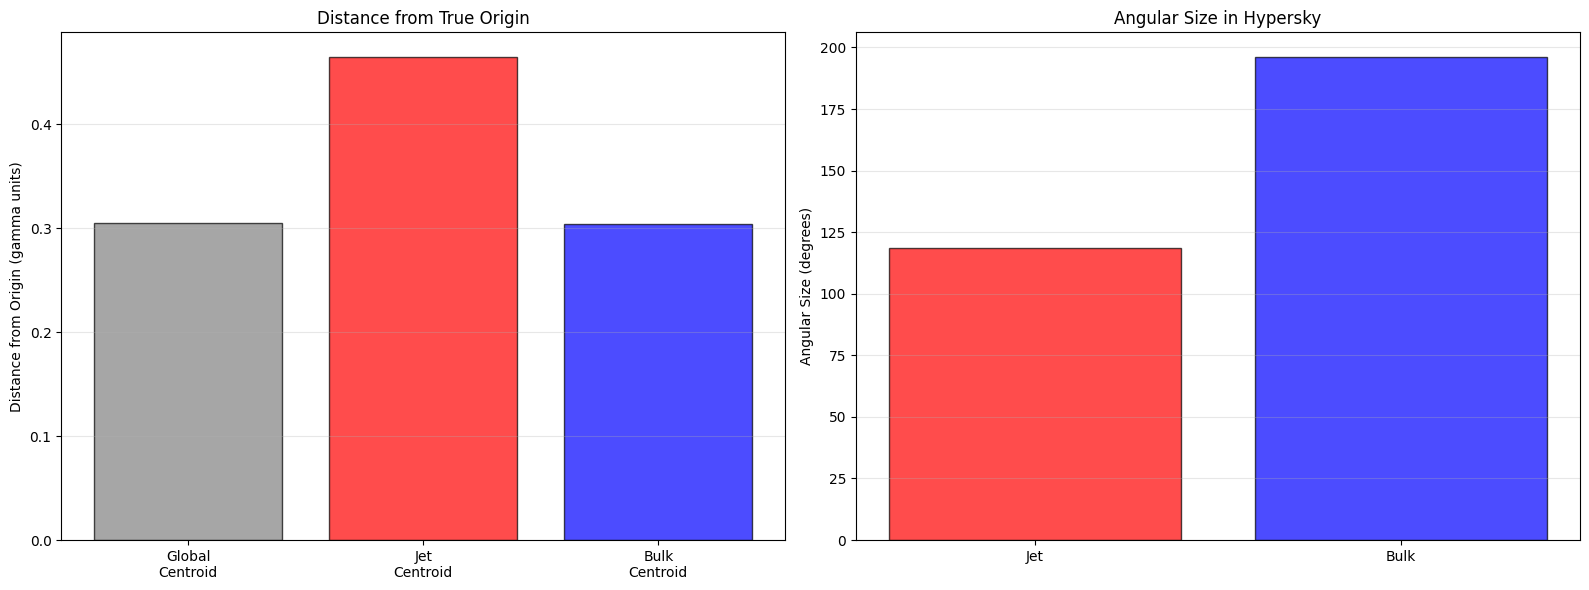

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Left: Distance from origin
ax = axes[0]
categories = ['Global\nCentroid', 'Jet\nCentroid', 'Bulk\nCentroid']
distances = [global_centroid_norm, jet_centroid_norm, bulk_centroid_norm]
colors = ['gray', 'red', 'blue']
ax.bar(categories, distances, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Distance from Origin (gamma units)')
ax.set_title('Distance from True Origin')
ax.grid(True, alpha=0.3, axis='y')

# Right: Angular size
ax = axes[1]
categories = ['Jet', 'Bulk']
angular_sizes_deg = [np.degrees(jet_angular_size), np.degrees(bulk_angular_size)]
colors = ['red', 'blue']
ax.bar(categories, angular_sizes_deg, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Angular Size (degrees)')
ax.set_title('Angular Size in Hypersky')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary

We tested the hypothesis that the jet subtends a large angle because it's small but close to the origin.

**Findings:**
- Jet centroid distance from origin: ??? gamma units
- Bulk centroid distance from origin: ??? gamma units
- Jet intrinsic size (mean radius): ??? gamma units
- Bulk intrinsic size (mean radius): ??? gamma units
- Jet angular size: ???° (??? radians)
- Bulk angular size: ???° (??? radians)

**Hypothesis verdict:**
- If jet is closer AND smaller but subtends larger angle → Confirmed!
- If jet is farther or larger → Need alternative explanation

The geometry of the jet reveals whether it's a compact nearby structure or a diffuse distant one.